In [1]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-us-election") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [2]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-us-election>

In [3]:
from pathlib import Path

global_data_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/")
global_data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log')

In [4]:
data_dir = global_data_dir / "focused"
data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused')

In [5]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [6]:
def paths_jsonl(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    yield from base_path.glob("*/*.jsonl.gz")

In [23]:
from json import loads, JSONDecodeError
from typing import Iterator
from gzip import GzipFile

def read_jsonl(path: Path) -> Iterator:
    print(f"Read JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as gzip_file:
            for line in gzip_file:
                try:
                    url = loads(line)
                except JSONDecodeError:
                    continue
                yield url
    except:
        return 

In [24]:
!pip install publicsuffixlist

In [25]:
from urllib.parse import urlsplit
from publicsuffixlist import PublicSuffixList

public_suffix_list = PublicSuffixList()

def domain(url: str) -> str:
    hostname = urlsplit(url).hostname
    if hostname is None:
        return None
    public_suffix = public_suffix_list.publicsuffix(hostname)
    second_level_domain = public_suffix_list.subdomain(hostname, 0)
    if second_level_domain is None:
        second_level_domain = public_suffix
    return second_level_domain

In [26]:
with Path("services.txt").open("rt") as file:
    alexa_services = [
        line.strip()
        for line in file
        if line
    ]
len(alexa_services)

1087

In [97]:
terms_de = {
    "corona virus",
    "covid 19",
    "covid-19",
    "sars cov 2",
    "sars-cov-2",
    # "world health organization",
    # "who",
    # "bundestagswahl",
    # "bundestagwahl",
    # "bundestag wahl",
}

In [98]:
from datetime import datetime

timeline_de = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .keyBy(lambda url: datetime.fromtimestamp(url["timestamp"]))\
    .mapValues(lambda url: url["query"].lower())\
    .filter(lambda timestamp_query: any(term in timestamp_query[1] for term in terms_de))\
    .collect()

In [99]:
len(timeline_de)

128844

In [100]:
from pandas import DataFrame

df = DataFrame([
    {
        "country": "Germany",
        "timestamp": timestamp,
    }
    for timestamp, query in timeline_de
])

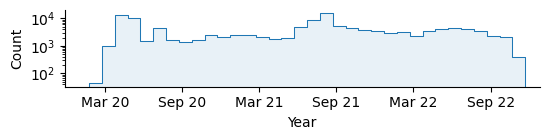

In [126]:
from seaborn import displot
from pandas import date_range

width = 6
aspect = 4
plot = displot(
    data=df,
    kind="hist",
    x="timestamp",
    element="step",
    aspect=aspect,
    height=width/aspect,
    binwidth=365/12,
    # bins=30,
    linewidth=0.75,
    alpha=0.1,
)
plot.set_axis_labels("Year", "Count")
# plot.refline(x=datetime(2002, 9, 22))
# plot.refline(x=datetime(2005, 9, 18))
# plot.refline(x=datetime(2009, 9, 27))
# plot.refline(x=datetime(2013, 9, 22))
# plot.refline(x=datetime(2017, 9, 24))
# plot.refline(x=datetime(2021, 9, 26))
mths = date_range(start='2020-03-06', end='2022-09-6', periods=6)
plot.set(xticks=mths.strftime('%Y-%m-%d'))
plot.set(xticklabels=mths.strftime('%b %y'))
plot.set(
    xlim=(datetime(2019, 12, 1), datetime(2022,12,31)),
    yscale="log",
)
plot.savefig("figures/plot-time-series-covid.pdf")
plot.savefig("figures/plot-time-series-covid.png")

In [27]:
domains_dem = {
    "democrats.org",
}

In [28]:
domains_rep = {
    "gop.com",
    # "gop.gov",
}

In [29]:
def us_reciprocal_ranks(results: list) -> tuple:
    domains = [domain(result["url"]) for result in results]
    rank_dem = None
    rank_rep = None
    for i, domain in enumerate(domains):
        if rank_dem is None and domain in domains_dem:
            rank_dem = i + 1
        if rank_rep is None and domain in domains_rep:
            rank_rep = i + 1
    reciprocal_rank_dem = 1 / rank_dem if rank_dem is not None else 0
    reciprocal_rank_rep = 1 / rank_rep if rank_rep is not None else 0
    return reciprocal_rank_dem, reciprocal_rank_rep

In [30]:
from statistics import mean

def mean_tuple(ranks: list) -> tuple:
    mean_rank_a = mean(rank for rank, _ in ranks)
    mean_rank_b = mean(rank for _, rank in ranks)
    return mean_rank_a, mean_rank_b

In [31]:
from json import loads
from pandas import DataFrame
from datetime import datetime

timeline = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .filter(lambda serp: serp["results"] is not None)\
    .filter(lambda serp: serp["offset"] is None or serp["offset"] == 0)\
    .filter(lambda serp: serp["page"] is None or serp["page"] <= 1)\
    .count()
    # .map(lambda serp: (serp["timestamp"], serp["results"]))\
    # .keyBy(datetime.fromtimestamp)\
    # .mapValues(us_reciprocal_ranks)\
    # .collect()
    # .map(lambda timestamp_results: (timestamp_results[0].year + (timestamp_results[0].month-1)/12 + (timestamp_results[0].day-1)/365, timestamp_results[1]))\
    # .groupByKey()\
    # .mapValues(mean_tuple)\

In [32]:
# len(timeline)
timeline

5482954

In [83]:
df = DataFrame([
    {
        "rank_dem": rank_dem,
        "language": language,
        "query_length": query_length,
        "count": count,
    }
    for (service, language, query_length), count in counts.items()
])
df.to_csv("query-length-counts.csv")
df

,service,language,query_length,count
0,wikimedia,en,32,654
1,wikimedia,None,9,3665
2,wikimedia,None,13,6724
3,wikimedia,it,26,67
4,wikimedia,sv,12,155
...,...,...,...,...
450642,wikimedia,ceb,46,1
450643,wikimedia,bs,1,1
450644,wikimedia,da,55,2
450645,wikimedia,sq,5,1


In [138]:
num_languages = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda url: url["query"])\
    .map(detect_language)\
    .distinct()\
    .count()
num_languages

104